In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utilities.utilities import visualize_3d_slice

In [7]:
pred_fp="/Users/huayinluo/Documents/stitchedpreds"
pred_imgs = os.listdir(pred_fp)
pred_imgs.sort()
gt_fp="/Users/huayinluo/Documents/gj_seg"
gt_imgs = os.listdir(gt_fp)
gt_imgs.sort()
print(len(pred_imgs))
tmp_fp=os.path.join(pred_fp, pred_imgs[0])
tmp_gt_fp=os.path.join(gt_fp, gt_imgs[0])
print(tmp_fp, tmp_gt_fp)
tmp = cv2.imread(tmp_fp, cv2.IMREAD_GRAYSCALE)
tmp_gt = cv2.imread(tmp_gt_fp, cv2.IMREAD_GRAYSCALE)
print(tmp.shape, tmp_gt.shape)

9
/Users/huayinluo/Documents/stitchedpreds/slice0.png /Users/huayinluo/Documents/gj_seg/sem_dauer_2_gj_gt_s100.png
(8192, 8192) (8328, 9360)


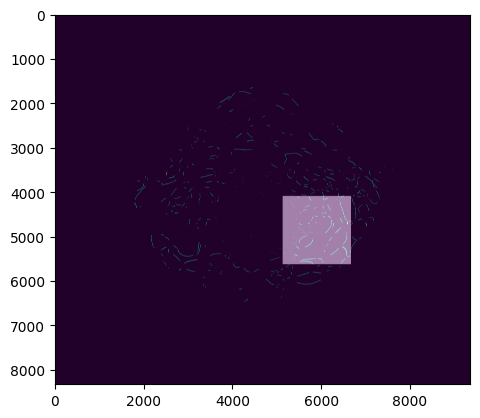

In [169]:
tmp_gt_copy = tmp_gt.copy()
depth = 3
num_x_slices = 3
num_y_slices = 3
start_x = 512*10
start_y = 512*8
end_x = start_x+512*num_x_slices
end_y = start_y+512*num_y_slices
# draw a red box from start_x to end_x, start_y to end_y
tmp_gt_copy[start_y:end_y, start_x:end_x] = 255

plt.imshow(tmp_gt_copy, cmap="gray")
plt.imshow(tmp, alpha=0.5)

In [170]:
# slices 100-110
# end_x, end_y = tmp.shape[1], tmp.shape[0]
# start_x,start_y=0,0
height, width = end_y-start_y, end_x-start_x
pred_vol = np.zeros((depth, height, width), dtype=np.uint8)
for i in range(depth):
    fp=os.path.join(pred_fp, pred_imgs[i])
    print(fp)
    tmp = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    pred_vol[i] = tmp[start_y:end_y, start_x:end_x]
    print("read ", i)
print(np.unique(pred_vol, return_counts=True))

/Users/huayinluo/Documents/stitchedpreds/slice0.png
read  0
/Users/huayinluo/Documents/stitchedpreds/slice1.png
read  1
/Users/huayinluo/Documents/stitchedpreds/slice2.png
read  2
(array([  0, 255], dtype=uint8), array([6884537,  193351]))


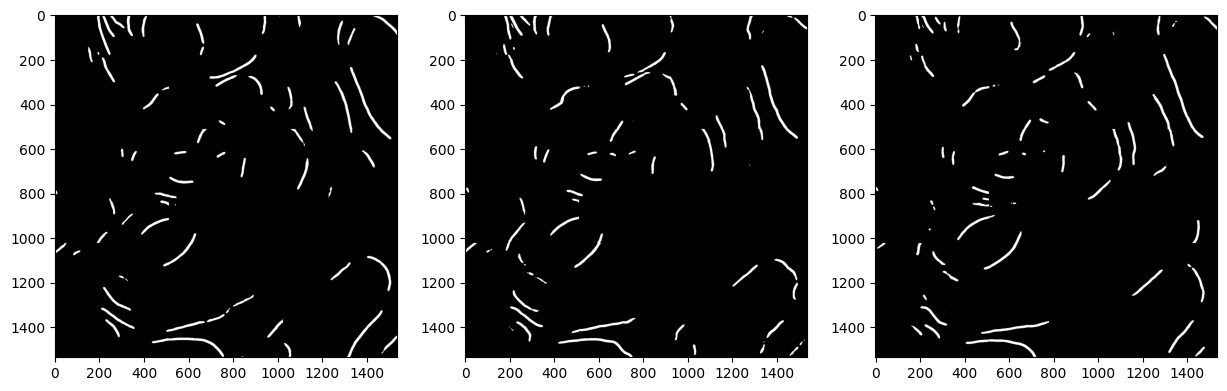

In [171]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(pred_vol,ax)

In [172]:
gt_vol = np.zeros((depth, height, width), dtype=np.uint8)
for i in range(depth):
    fp=os.path.join(gt_fp, gt_imgs[i])
    print(fp)
    tmp = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    gt_vol[i] = tmp[start_y:end_y, start_x:end_x]
    print("read ", i)
    
gt_vol[gt_vol != 0] = 255
print(np.unique(gt_vol, return_counts=True))

/Users/huayinluo/Documents/gj_seg/sem_dauer_2_gj_gt_s100.png
read  0
/Users/huayinluo/Documents/gj_seg/sem_dauer_2_gj_gt_s101.png
read  1
/Users/huayinluo/Documents/gj_seg/sem_dauer_2_gj_gt_s102.png
read  2
(array([  0, 255], dtype=uint8), array([6828493,  249395]))


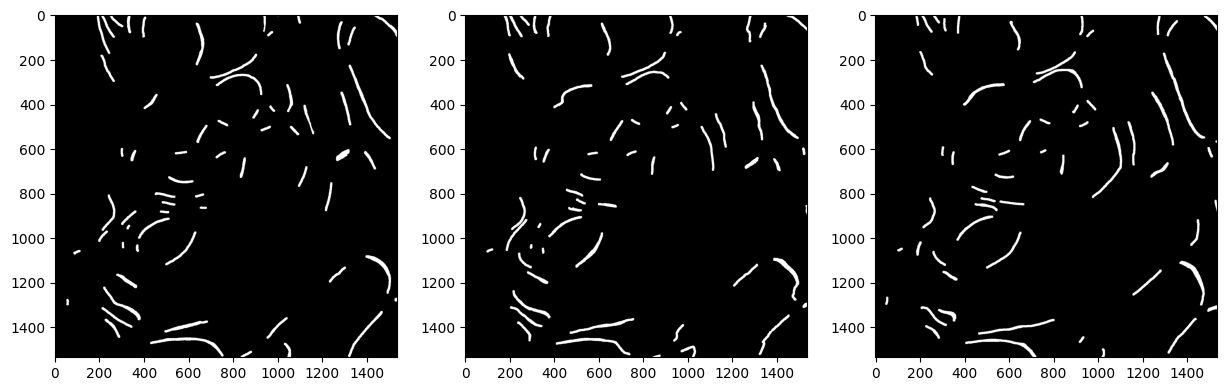

In [173]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(gt_vol,ax)

In [174]:
import numpy as np
from scipy.ndimage import label
def get_precision_recall(pred_vol, gt_vol, entity_thresh=0.5):
    labeled_array, num_features = label(pred_vol)
    print(f"Number of entities found in pred: {num_features}")
    # Extract each labeled component into a separate 3D array
    true_positive_components = []
    true_positive_gt_components = []
    false_positive_components = []
    false_negative_components = []
    all_components = []
    tp = 0
    fp = 0
    fn = 0
    for i in range(1, num_features + 1):
        component = (labeled_array == i).astype(np.uint8) * 255
        
        # check intersection of component with gt
        num_intersect = np.count_nonzero(component[gt_vol != 0]) # nonzero pixels in component where gt is also nonzero
        num_pred = np.count_nonzero(component)
        proportion_intersect = num_intersect/num_pred
        
        if proportion_intersect >= entity_thresh:
            true_positive_components.append(component)
            tp += 1
        else:
            false_positive_components.append(component)
            fp += 1
        all_components.append(component)

    # Label connected components
    labeled_array, num_gt_features = label(gt_vol)
    print(f"Number of entities found in gt: {num_gt_features}")
    tp_intersect_gt = 0
    for i in range(1, num_gt_features + 1):
        component = (labeled_array == i).astype(np.uint8) * 255
        num_intersect = np.count_nonzero(component[pred_vol != 0])
        num_gt = np.count_nonzero(component)
        if num_intersect/num_gt >= entity_thresh:
            tp_intersect_gt += 1
            true_positive_gt_components.append(component)
        else:
            fn += 1
            false_negative_components.append(component)
    print("---------------------------------")
    print(f"(criteria: >{entity_thresh*100:.2f}% of pred component intersect with gt component)")
    print(f"Entity precision ({tp}/{tp+fp}): {(tp/(tp+fp)):.3f}")
    print(f"Entity recall ({tp}/{tp+fn}): {(tp/(tp+fn)):.3f}")
    print("---------------------------------")
    print(f"(criteria: pred component covers >{(entity_thresh*100):.2f}% of gt component)")
    print(f"Entity precision ({tp_intersect_gt}/{tp_intersect_gt+fp}): {(tp_intersect_gt/(tp_intersect_gt+fp)):.3f}")
    print(f"Entity recall ({tp_intersect_gt}/{tp_intersect_gt+fn}): {(tp_intersect_gt/(tp_intersect_gt+fn)):.3f}")
    precision_gt = tp_intersect_gt/(tp_intersect_gt+fp)
    recall_gt = tp_intersect_gt/(tp_intersect_gt+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components, all_components

In [175]:
import time
entity_threshes = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
precision_dict = {}
recall_dict = {}
precision_gt_dict = {}
recall_gt_dict = {}
start_time = time.time()
for entity_thresh in entity_threshes:
# Label connected components
    precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components, all_components = get_precision_recall(pred_vol, gt_vol, entity_thresh)
    precision_dict[entity_thresh] = precision
    recall_dict[entity_thresh] = recall
    precision_gt_dict[entity_thresh] = precision_gt
    recall_gt_dict[entity_thresh] = recall_gt
    print(f"=========================================== entity thresh: {entity_thresh} (time: {(time.time()-start_time):.2f}s)===========================================")


Number of entities found in pred: 134
Number of entities found in gt: 85
---------------------------------
(criteria: >0.00% of pred component intersect with gt component)
Entity precision (134/134): 1.000
Entity recall (134/134): 1.000
---------------------------------
(criteria: pred component covers >0.00% of gt component)
Entity precision (85/85): 1.000
Entity recall (85/85): 1.000
=========================================== entity thresh: 0 (time: 2.85s)===========================================
Number of entities found in pred: 134
Number of entities found in gt: 85
---------------------------------
(criteria: >10.00% of pred component intersect with gt component)
Entity precision (103/134): 0.769
Entity recall (103/127): 0.811
---------------------------------
(criteria: pred component covers >10.00% of gt component)
Entity precision (61/92): 0.663
Entity recall (61/85): 0.718
=========================================== entity thresh: 0.1 (time: 5.13s)==========================

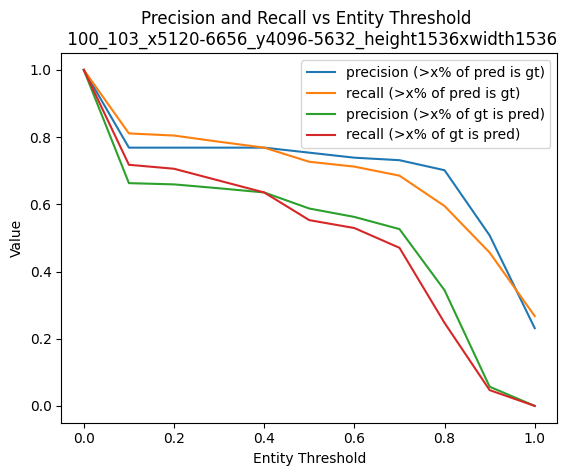

In [176]:
SAVE = True
suffix=f"100_103_x{start_x}-{end_x}_y{start_y}-{end_y}_height{height}xwidth{width}"
plt.plot(precision_dict.keys(), precision_dict.values(), label="precision (>x% of pred is gt)")
plt.plot(recall_dict.keys(), recall_dict.values(), label="recall (>x% of pred is gt)")
plt.title(f"Precision and Recall vs Entity Threshold \n {suffix}")
plt.plot(precision_gt_dict.keys(), precision_gt_dict.values(), label="precision (>x% of gt is pred)")
plt.plot(recall_gt_dict.keys(), recall_gt_dict.values(), label="recall (>x% of gt is pred)")
plt.xlabel("Entity Threshold")
plt.ylabel("Value")
plt.legend()
if SAVE:
    plt.savefig(f"graph_{suffix}.png")
plt.show()

In [223]:
entity_thresh=0.01
precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components, all_components = get_precision_recall(pred_vol, gt_vol, entity_thresh)

Number of entities found in pred: 134
Number of entities found in gt: 85
---------------------------------
(criteria: >1.00% of pred component intersect with gt component)
Entity precision (104/134): 0.776
Entity recall (104/124): 0.839
---------------------------------
(criteria: pred component covers >1.00% of gt component)
Entity precision (65/95): 0.684
Entity recall (65/85): 0.765


In [224]:
# createa a 3d volume of all components
all_components_vol = np.zeros((depth, height, width, 3), dtype=np.uint8)

# generate random colors for each component
colors = np.random.randint(0, 255, (len(all_components), 3))
for i, component in enumerate(all_components):
    for j in range(3):
        all_components_vol[:, :, :, j] += component * colors[i][j]
    print(f"added component {i}/{len(all_components)}", end="\r")

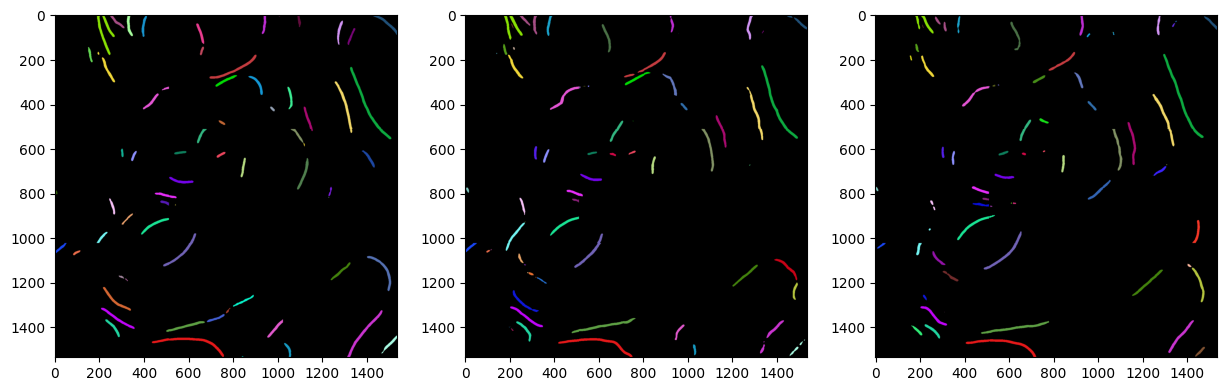

In [225]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(all_components_vol, ax)
plt.savefig(f"all_components_{suffix}.png")

In [226]:
print(len(true_positive_components), len(true_positive_gt_components), len(false_positive_components), len(false_negative_components))

104 65 30 20


In [227]:
# plot the components (different colors for tp, fp, fn)
combined_img = np.zeros((depth, height, width, 3), dtype=np.uint8)
# True positives = green
for i, component in enumerate(true_positive_components):
    combined_img[component != 0] = [0, 255, 0]
# False positives = red
for i, component in enumerate(false_positive_components):
    combined_img[component != 0] = [255, 0, 0]
# False negatives = blue
for i, component in enumerate(false_negative_components):
    combined_img[component != 0] = [0, 0, 255]
                   

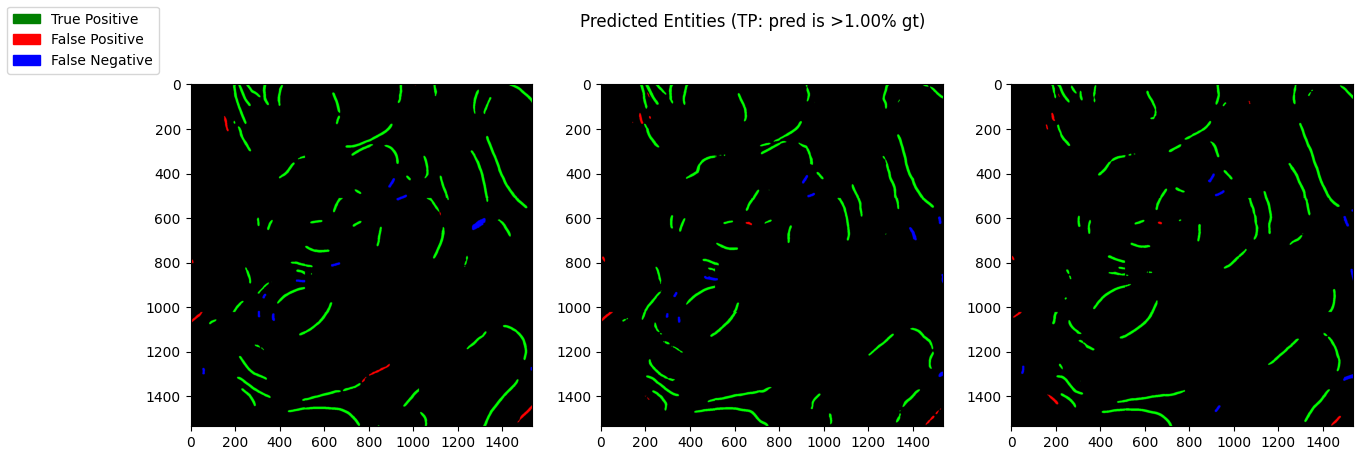

In [228]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(combined_img, ax)
plt.suptitle(f"Predicted Entities (TP: pred is >{entity_thresh*100:.2f}% gt)")

# manually make legend with matplotlib patches
import matplotlib.patches as mpatches
tp_patch = mpatches.Patch(color='green', label='True Positive')
fp_patch = mpatches.Patch(color='red', label='False Positive')
fn_patch = mpatches.Patch(color='blue', label='False Negative')
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='upper left')
plt.savefig(f"tp_{suffix}_{entity_thresh}.png")

In [229]:
# plot the components (different colors for tp, fp, fn)
combined_img = np.zeros((depth, height, width, 3), dtype=np.uint8)
# True positives = green
for i, component in enumerate(true_positive_gt_components):
    combined_img[component != 0] = [0, 255, 0]
# False positives = red
for i, component in enumerate(false_positive_components):
    combined_img[component != 0] = [255, 0, 0]
# False negatives = blue
for i, component in enumerate(false_negative_components):
    combined_img[component != 0] = [0, 0, 255]
                   

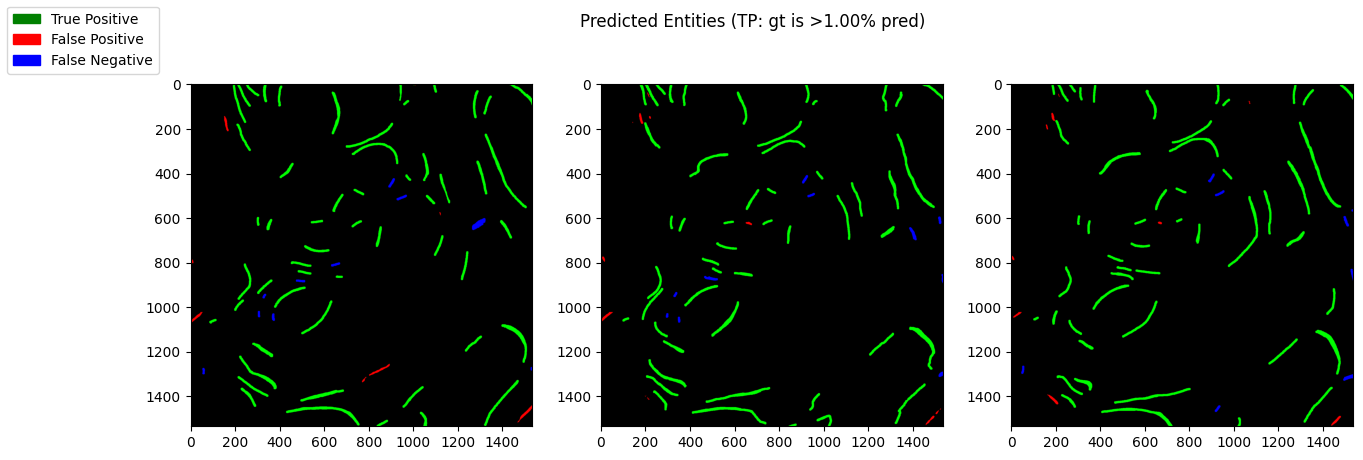

In [230]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(combined_img, ax)
plt.suptitle(f"Predicted Entities (TP: gt is >{entity_thresh*100:.2f}% pred)")

# manually make legend with matplotlib patches
import matplotlib.patches as mpatches
tp_patch = mpatches.Patch(color='green', label='True Positive')
fp_patch = mpatches.Patch(color='red', label='False Positive')
fn_patch = mpatches.Patch(color='blue', label='False Negative')
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='upper left')
plt.savefig(f"tp_gt_{suffix}_{entity_thresh}.png")

# 2D

In [249]:
def get_precision_recall_2d(pred_vol, gt_vol, entity_thresh=0.5):
    total_tp=0
    total_fp=0
    total_fn=0
    total_tp_gt=0
    true_positive_components = []
    true_positive_gt_components = []
    false_positive_components = []
    false_negative_components = []
    for k in range(depth):
        pred_img = pred_vol[k]
        gt_img = gt_vol[k]
        gt_img[gt_img != 0] = 255

        labeled_array, num_features = label(pred_img)
        tp = 0
        tp_gt = 0
        fp = 0
        fn = 0
        for i in range(1, num_features + 1):
            component = (labeled_array == i).astype(np.uint8) * 255
            # check intersection of component with gt
            num_intersect = np.count_nonzero(component[gt_img != 0]) # nonzero pixels in component where gt is also nonzero
            num_pred = np.count_nonzero(component)
            proportion_intersect = num_intersect/num_pred
            if proportion_intersect >= entity_thresh:
                true_positive_components.append(component)
                tp += 1
            else:
                false_positive_components.append(component)
                fp += 1

        labeled_array, num_gt_features = label(gt_img)
        for i in range(1, num_gt_features + 1):
            component = (labeled_array == i).astype(np.uint8) * 255
            num_intersect = np.count_nonzero(component[pred_img != 0])
            num_gt = np.count_nonzero(component)
            if num_intersect/num_gt >= entity_thresh:
                true_positive_gt_components.append(component)
                tp_gt += 1
            else:
                false_negative_components.append(component)
                fn += 1
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
        total_tp_gt += tp_gt
        print(f"--------Slice {k}--------")
        print(f"Number of entities found | pred: {num_features} | gt: {num_gt_features}")
        print(f"Entity precision ({tp}/{tp+fp}): {tp/(tp+fp):.3f}")
        print(f"Entity recall ({tp}/{tp+fn}): {tp/(tp+fn):.3f}")
    print(f"------------------------Total------------------------")
    print(f"Total Entity precision ({total_tp}/{total_tp+total_fp}): {total_tp/(total_tp+total_fp):.3f}")
    print(f"Total Entity recall ({total_tp}/{total_tp+total_fn}): {total_tp/(total_tp+total_fn):.3f}")
    precision = total_tp/(total_tp+total_fp)
    recall = total_tp/(total_tp+total_fn)
    precision_gt = total_tp_gt/(total_tp_gt+total_fp)
    recall_gt = total_tp_gt/(total_tp_gt+total_fn)
    return precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components

In [250]:
import time
entity_threshes = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
precision_dict = {}
recall_dict = {}
precision_gt_dict = {}
recall_gt_dict = {}
start_time = time.time()
for entity_thresh in entity_threshes:
# Label connected components
    precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components = get_precision_recall_2d(pred_vol, gt_vol, entity_thresh)
    precision_dict[entity_thresh] = precision
    recall_dict[entity_thresh] = recall
    precision_gt_dict[entity_thresh] = precision_gt
    recall_gt_dict[entity_thresh] = recall_gt
    print(f"=========================================== entity thresh: {entity_thresh} (time: {(time.time()-start_time):.2f}s)===========================================")


--------Slice 0--------
Number of entities found | pred: 70 | gt: 65
Entity precision (70/70): 1.000
Entity recall (70/70): 1.000
--------Slice 1--------
Number of entities found | pred: 88 | gt: 61
Entity precision (88/88): 1.000
Entity recall (88/88): 1.000
--------Slice 2--------
Number of entities found | pred: 79 | gt: 58
Entity precision (79/79): 1.000
Entity recall (79/79): 1.000
------------------------Total------------------------
Total Entity precision (237/237): 1.000
Total Entity recall (237/237): 1.000
=========================================== entity thresh: 0 (time: 1.07s)===========================================
--------Slice 0--------
Number of entities found | pred: 70 | gt: 65
Entity precision (59/70): 0.843
Entity recall (59/73): 0.808
--------Slice 1--------
Number of entities found | pred: 88 | gt: 61
Entity precision (67/88): 0.761
Entity recall (67/84): 0.798
--------Slice 2--------
Number of entities found | pred: 79 | gt: 58
Entity precision (66/79): 0.835


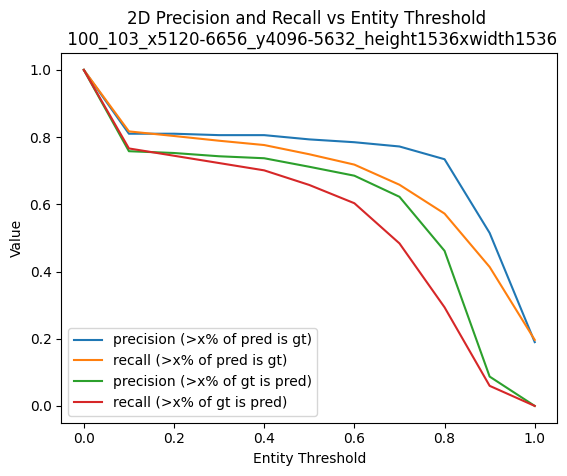

In [252]:
SAVE = True
suffix=f"100_103_x{start_x}-{end_x}_y{start_y}-{end_y}_height{height}xwidth{width}"
plt.plot(precision_dict.keys(), precision_dict.values(), label="precision (>x% of pred is gt)")
plt.plot(recall_dict.keys(), recall_dict.values(), label="recall (>x% of pred is gt)")
plt.title(f"2D Precision and Recall vs Entity Threshold \n {suffix}")
plt.plot(precision_gt_dict.keys(), precision_gt_dict.values(), label="precision (>x% of gt is pred)")
plt.plot(recall_gt_dict.keys(), recall_gt_dict.values(), label="recall (>x% of gt is pred)")
plt.xlabel("Entity Threshold")
plt.ylabel("Value")
plt.legend()
if SAVE:
    plt.savefig(f"graph2d_{suffix}.png")
plt.show()

In [254]:
entity_thresh=0.01
precision_gt, recall_gt, precision, recall, true_positive_components, true_positive_gt_components, false_positive_components, false_negative_components = get_precision_recall_2d(pred_vol, gt_vol, entity_thresh)

--------Slice 0--------
Number of entities found | pred: 70 | gt: 65
Entity precision (60/70): 0.857
Entity recall (60/72): 0.833
--------Slice 1--------
Number of entities found | pred: 88 | gt: 61
Entity precision (67/88): 0.761
Entity recall (67/81): 0.827
--------Slice 2--------
Number of entities found | pred: 79 | gt: 58
Entity precision (66/79): 0.835
Entity recall (66/77): 0.857
------------------------Total------------------------
Total Entity precision (193/237): 0.814
Total Entity recall (193/230): 0.839


In [255]:
print(len(true_positive_components), len(true_positive_gt_components), len(false_positive_components), len(false_negative_components))

193 147 44 37


In [256]:
# plot the components (different colors for tp, fp, fn)
combined_img = np.zeros((depth, height, width, 3), dtype=np.uint8)
# True positives = green
for k in range(depth):
    for i, component in enumerate(true_positive_components):
        combined_img[k][component != 0] = [0, 255, 0]
    # False positives = red
    for i, component in enumerate(false_positive_components):
        combined_img[k][component != 0] = [255, 0, 0]
    # False negatives = blue
    for i, component in enumerate(false_negative_components):
        combined_img[k][component != 0] = [0, 0, 255]

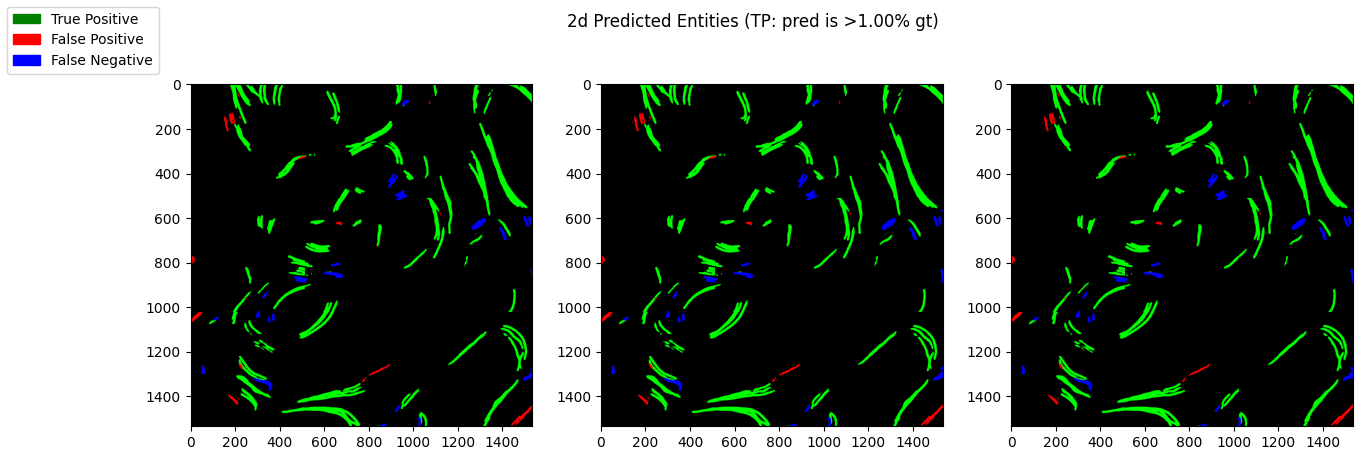

In [257]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(combined_img, ax)
plt.suptitle(f"2d Predicted Entities (TP: pred is >{entity_thresh*100:.2f}% gt)")

# manually make legend with matplotlib patches
import matplotlib.patches as mpatches
tp_patch = mpatches.Patch(color='green', label='True Positive')
fp_patch = mpatches.Patch(color='red', label='False Positive')
fn_patch = mpatches.Patch(color='blue', label='False Negative')
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='upper left')
plt.savefig(f"2dtp_{suffix}_{entity_thresh}.png")

In [258]:
# plot the components (different colors for tp, fp, fn)
combined_img = np.zeros((depth, height, width, 3), dtype=np.uint8)
# True positives = green
for i, component in enumerate(true_positive_gt_components):
        combined_img[k][component != 0] = [0, 255, 0]
    # False positives = red
    for i, component in enumerate(false_positive_components):
        combined_img[k][component != 0] = [255, 0, 0]
    # False negatives = blue
    for i, component in enumerate(false_negative_components):
        combined_img[k][component != 0] = [0, 0, 255]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1536

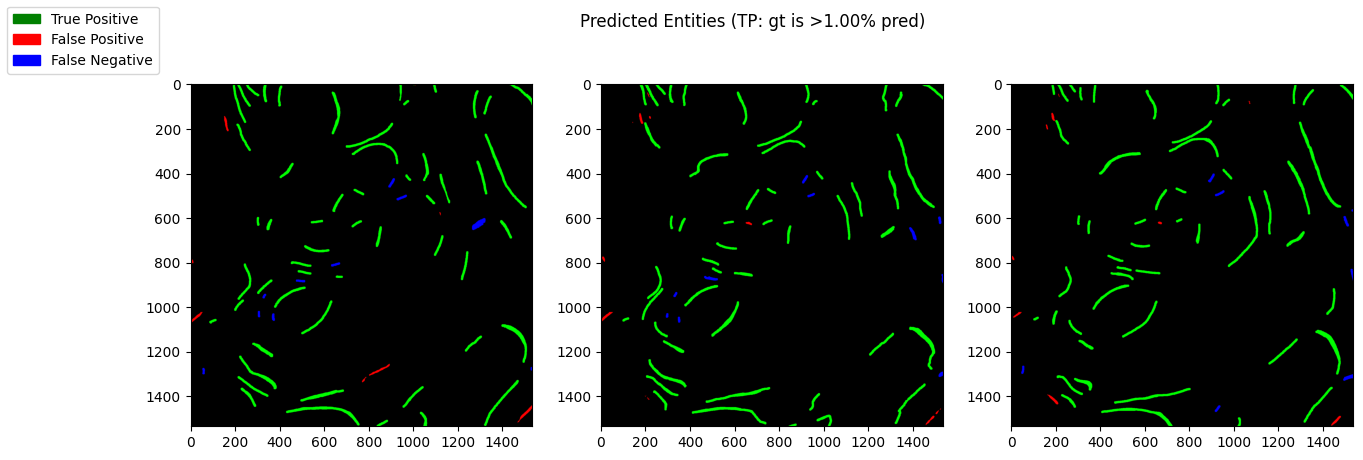

In [ ]:
fig, ax = plt.subplots(1, depth, figsize=(15, 5))
visualize_3d_slice(combined_img, ax)
plt.suptitle(f"Predicted Entities (TP: gt is >{entity_thresh*100:.2f}% pred)")

# manually make legend with matplotlib patches
import matplotlib.patches as mpatches
tp_patch = mpatches.Patch(color='green', label='True Positive')
fp_patch = mpatches.Patch(color='red', label='False Positive')
fn_patch = mpatches.Patch(color='blue', label='False Negative')
fig.legend(handles=[tp_patch, fp_patch, fn_patch], loc='upper left')
plt.savefig(f"tp_gt_{suffix}_{entity_thresh}.png")